In [1]:
import numpy as np
import cv2
import os
import re
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Dataset loaded
190 224 (224, 224) 60 190 60


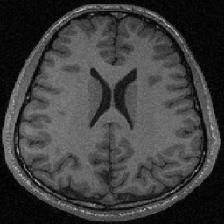

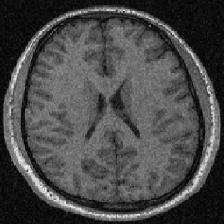

In [ ]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_190/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_190/train/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_190/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_190/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(1)
    return np.array(images_train), np.array(images_test), np.array(labels_train), np.array(labels_test)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")
print(len(X_train_ml),len(X_train_ml[0]), X_train_ml[0].shape,len(X_test_ml), len(y_train_ml), len(y_test_ml))

from google.colab.patches import cv2_imshow
cv2_imshow(X_train_ml[5])
cv2_imshow(X_test_ml[5])

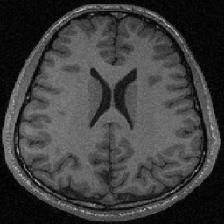

(190, 55)

In [ ]:
from skimage.feature import graycomatrix, graycoprops
imgs = X_train_ml.astype(np.int32)
labels = y_train_ml.astype(np.int32)
cv2_imshow(imgs[5])
# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

glcm_df.shape

In [ ]:
from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape

(190, 5409)

In [ ]:
from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
#combined_df = glcm_df
#combined_df = lbp_df
#combined_df = hog_df
print(combined_df)
# Assuming 'label' is the target variable

X_train_df = combined_df.drop(columns=['label'])
y_train_df = combined_df['label']

#X = combined_df.drop(combined_df.index[-1])
#y = combined_df.iloc[-1]

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_train = scaler_combined.fit_transform(X_train_df.values)

        hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0    0.226452  0.115923  0.160223  0.173143  0.226452  0.136537  0.146462   
1    0.211413  0.211413  0.211413  0.191789  0.211413  0.096446  0.169225   
2    0.222086  0.079175  0.146674  0.066373  0.222086  0.079856  0.124094   
3    0.215333  0.085689  0.187427  0.129934  0.215333  0.162799  0.137545   
4    0.212166  0.124422  0.188900  0.190917  0.219322  0.119070  0.149420   
..        ...       ...       ...       ...       ...       ...       ...   
185  0.211113  0.110955  0.143958  0.159629  0.211113  0.211113  0.211113   
186  0.217160  0.082611  0.217160  0.167299  0.217160  0.100929  0.137234   
187  0.215597  0.145128  0.156356  0.162644  0.215597  0.057460  0.167433   
188  0.211341  0.130827  0.167808  0.175051  0.211341  0.188755  0.206789   
189  0.222259  0.087637  0.093399  0.081322  0.222259  0.136189  0.148652   

        hog_7     hog_8     hog_9  ...  energy_0  energy_0.5235987755982988

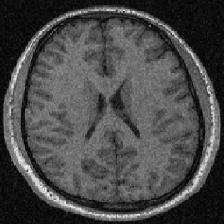

       hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0   0.220318  0.142592  0.159361  0.115057  0.220318  0.129215  0.220318   
1   0.230209  0.139306  0.184140  0.121309  0.217577  0.070912  0.175944   
2   0.228579  0.072806  0.178778  0.092244  0.228579  0.113729  0.184714   
3   0.206246  0.133437  0.153602  0.146377  0.215684  0.117818  0.206529   
4   0.217780  0.134067  0.189440  0.113604  0.214190  0.136528  0.179718   
5   0.218962  0.115502  0.136250  0.133514  0.218962  0.188544  0.218962   
6   0.219682  0.165734  0.124840  0.126925  0.183663  0.112871  0.213146   
7   0.219003  0.112835  0.161225  0.191180  0.219003  0.103024  0.164115   
8   0.217350  0.154263  0.162032  0.153746  0.218431  0.176599  0.189903   
9   0.211703  0.067593  0.134593  0.102490  0.205073  0.103507  0.157856   
10  0.223134  0.085131  0.185511  0.149276  0.223134  0.097601  0.168048   
11  0.217431  0.140061  0.157974  0.146830  0.217431  0.149783  0.217431   
12  0.184428

In [ ]:
from skimage.feature import graycomatrix, graycoprops
imgs = X_test_ml.astype(np.int32)
labels = y_test_ml.astype(np.int32)
cv2_imshow(imgs[5])

# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

glcm_df.shape

from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape

from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
#combined_df = glcm_df
#combined_df = lbp_df
#combined_df = hog_df
print(combined_df)
# Assuming 'label' is the target variable

X_test_df = combined_df.drop(columns=['label'])
y_test_df = combined_df['label']

#X = combined_df.drop(combined_df.index[-1])
#y = combined_df.iloc[-1]

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_test = scaler_combined.fit_transform(X_test_df.values)

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_ml = label_encoder.fit_transform(y_train_df)
y_test_ml = label_encoder.fit_transform(y_test_df)

print(X_scaled_train.shape, X_scaled_test.shape, y_train_ml.shape, y_test_ml.shape)

X_train_ml_rfe, X_test_ml_rfe, y_train_ml_rfe, y_test_ml_rfe = X_scaled_train, X_scaled_test, y_train_ml, y_test_ml

num_selected_features = 512


from sklearn.linear_model import LinearRegression
estimator = LinearRegression()

rfe = RFE(estimator, n_features_to_select=num_selected_features,importance_getter='coef_')

# Fit the RFE model to the training data
X_train_rfe = rfe.fit_transform(X_train_ml_rfe, y_train_ml_rfe)

# Get the selected feature names
X = pd.concat([pd.DataFrame(X_train_ml_rfe),pd.DataFrame(X_test_ml_rfe)],axis=0)
selected_feature_names = X.columns[rfe.support_]

# Convert X_train_rfe to a DataFrame with column names
X_train_ml_rfe = pd.DataFrame(X_train_rfe, columns=selected_feature_names)

# Convert X_train_rfe to a DataFrame with column names
#X_train_ml_rfe = pd.DataFrame(X_train_rfe, columns=selected_feature_names)
print(X_train_ml_rfe.shape,y_train_ml_rfe.shape)

# Convert X_train_rfe to a DataFrame with column names
X_test_ml_rfe = X_test_ml_rfe[:, rfe.support_]
print(X_test_ml_rfe.shape,y_test_ml_rfe.shape)



(190, 5664) (60, 5664) (190,) (60,)
(190, 512) (190,)
(60, 512) (60,)


In [ ]:
for i in X_train_ml_rfe.columns.tolist():
    print(i, end=' ')
best_columns = pd.DataFrame(X_train_ml_rfe.columns.tolist())
best_columns.to_csv('/content/gdrive/My Drive/Colab Notebooks/best_columns.csv', index=False)

16 44 52 56 73 75 99 112 148 152 246 262 298 301 302 322 326 333 348 364 381 386 405 428 463 477 484 487 514 522 559 576 583 601 607 624 625 626 631 632 633 638 646 657 662 671 676 684 685 732 772 805 812 830 877 893 937 952 954 955 976 1007 1016 1025 1031 1033 1036 1040 1047 1060 1066 1115 1117 1141 1156 1233 1276 1293 1300 1322 1325 1345 1349 1352 1354 1355 1361 1365 1368 1369 1373 1376 1378 1379 1393 1397 1398 1404 1416 1419 1432 1437 1450 1461 1465 1470 1474 1489 1491 1494 1522 1539 1541 1555 1557 1559 1561 1585 1609 1631 1633 1654 1655 1676 1683 1700 1726 1737 1741 1742 1750 1752 1753 1754 1761 1769 1774 1776 1777 1778 1784 1793 1798 1832 1837 1840 1856 1857 1870 1889 1894 1903 1920 1934 1949 1957 1958 1959 1961 1973 1985 2040 2064 2083 2089 2098 2099 2113 2126 2138 2141 2150 2152 2153 2154 2158 2175 2176 2177 2178 2184 2186 2199 2220 2239 2240 2267 2289 2291 2296 2328 2332 2342 2349 2357 2366 2373 2422 2424 2433 2460 2464 2484 2485 2498 2499 2507 2508 2525 2526 2531 2532 2538 254

Dataset loaded
160 224 (224, 224, 3) 30 60 160 30 60


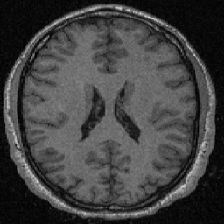

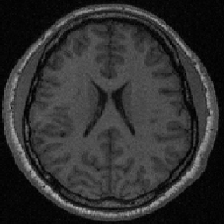

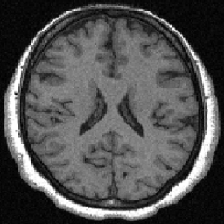

In [ ]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_val/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_val/train/schizophrenia'
healthy_path_val = '/content/gdrive/My Drive/Colab Notebooks/dataset_val/val/healthy'
schizophrenia_path_val = '/content/gdrive/My Drive/Colab Notebooks/dataset_val/val/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_val/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_val/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_val = []
    images_test = []
    labels_train = []
    labels_val = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(image)#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_train.append(image)#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_train.append(1)
    for img in os.listdir(healthy_path_val):
        img_path = os.path.join(healthy_path_val, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_val.append(image)#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_val.append(0)
    for img in os.listdir(schizophrenia_path_val):
        img_path = os.path.join(schizophrenia_path_val, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_val.append(image)#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_val.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(image)#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        #image = preprocess_input(image)
        images_test.append(image)#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        labels_test.append(1)
    return np.array(images_train), np.array(images_val), np.array(images_test), np.array(labels_train),  np.array(labels_val), np.array(labels_test)

X_train_dl, X_val_dl, X_test_dl, y_train_dl, y_val_dl, y_test_dl = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")

#print(X_train_dl, X_test_dl, y_train_dl, y_test_dl)
print(len(X_train_dl),len(X_train_dl[0]), X_train_dl[0].shape,len(X_val_dl), len(X_test_dl), len(y_train_dl), len(y_val_dl), len(y_test_dl))

from google.colab.patches import cv2_imshow
cv2_imshow(X_train_dl[5])
cv2_imshow(X_val_dl[5])
cv2_imshow(X_test_dl[5])

In [ ]:
import os
import time
import numpy as np
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


X_train_dl_split, X_val_dl_split, X_test_dl_split, y_train_dl_split, y_val_dl_split, y_test_dl_split  = X_train_dl, X_val_dl, X_test_dl, to_categorical(y_train_dl, num_classes=2), to_categorical(y_val_dl, num_classes=2), to_categorical(y_test_dl, num_classes=2)

print(len(X_train_dl_split),len(X_train_dl_split[0]), X_train_dl_split[0].shape,len(X_val_dl_split), len(X_test_dl_split), len(y_train_dl_split), len(y_val_dl_split), len(y_test_dl_split))

def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# Build and compile the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
base_model.trainable = False

# Freeze all layers except the last 3 convolutional layers
for layer in base_model.layers[-15:]:
    layer.trainable = True

print_layer_trainable()

model = Sequential([
    layers.Rescaling(1./224),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])

#model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Chackpoint
tl_checkpoint_h5 = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/Colab Notebooks/vgg19_best_weights.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
tl_checkpoint_tf = ModelCheckpoint(filepath = 'vgg19_best_weights.tf', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
# EarlyStopping
#early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

#ReduceLROnPlateau to stabilize the training process of the model
#rop_callback = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 10, verbose = 1, factor = 0.5, min_lr = 0.000001)

# Extra Data augmentation and training
# Define ImageDataGenerator for training data with data augmentation and other parameters
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define ImageDataGenerator for validation data (without data augmentation)
val_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_train_generator = train_datagen.flow(X_train_dl_split, y_train_dl_split, batch_size=5)
train_val_generator = val_datagen.flow(X_val_dl_split, y_val_dl_split, batch_size=5)


160 224 (224, 224, 3) 30 60 160 30 60
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPoolin

In [ ]:
%%time

history = model.fit(
    #train_generator,
    x=X_train_dl_split,
    y = y_train_dl_split,
    epochs=1,
    #validation_data=val_generator,
    validation_data=(X_val_dl_split, y_val_dl_split),
    callbacks = [tl_checkpoint_h5,tl_checkpoint_tf]#, CSVLogger('/content/gdrive/My Drive/Colab Notebooks/')]
)


5/5 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.4938 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 145s 29s/step - loss: 1.1404 - accuracy: 0.4938 - val_loss: 0.8467 - val_accuracy: 0.5000
CPU times: user 3min 30s, sys: 13.7 s, total: 3min 44s
Wall time: 2min 25s


2/2 [==============================] - 0s 132ms/step


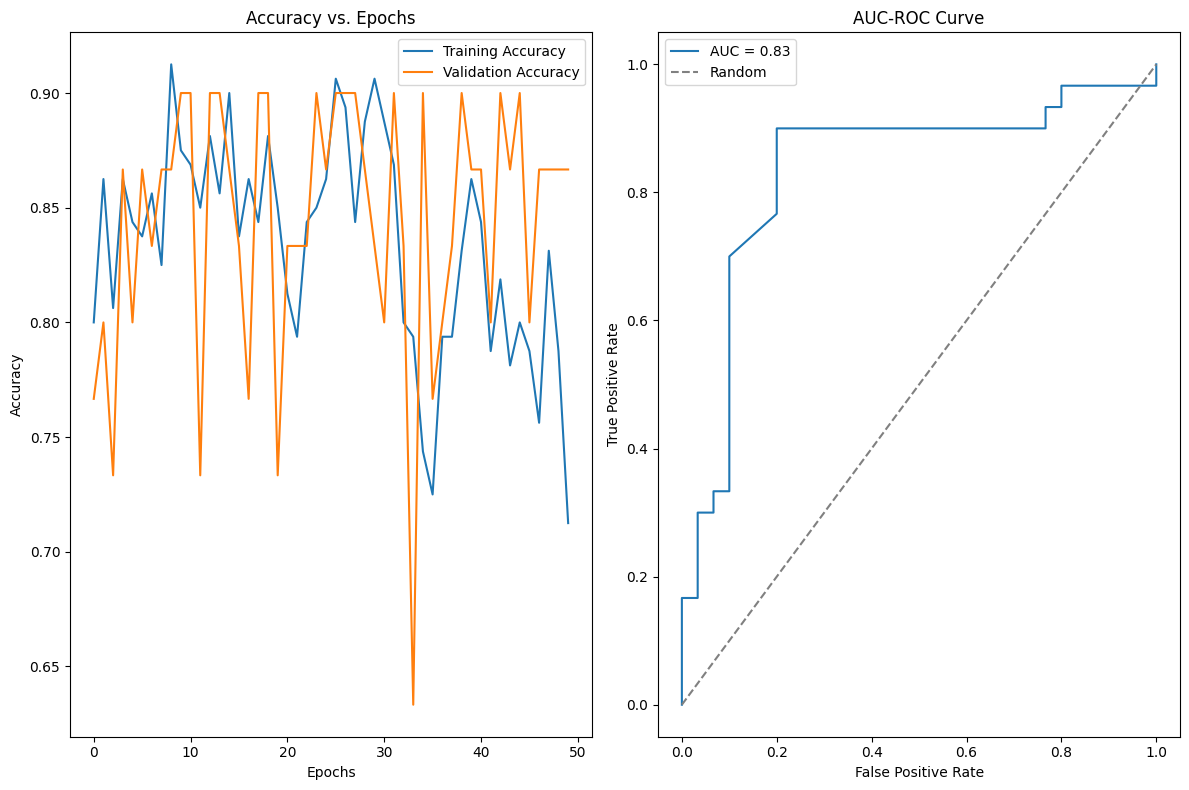

Test loss: 0.5394534468650818
Test accuracy: 0.8166666626930237
Sensitivity(recall): 0.8333333333333334
Specificity: 0.8
Precision: 0.8064516129032258
F1 Score: 0.819672131147541
AUC-ROC Score: 0.8344444444444444
[[24  6]
 [ 5 25]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)        

In [ ]:

#best_weights_path = 'vgg19_best_weights.h5'
#model.load_weights(best_weights_path)
# Evaluate the model
scores = model.evaluate(X_test_dl_split, y_test_dl_split, verbose=1)
y_pred_dl = model.predict(X_test_dl_split)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(y_test_dl_split, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

# Plot training history
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Corrected ylabel to 'Accuracy'
plt.title('Accuracy vs. Epochs')
plt.legend()

# Plot AUC-ROC
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_dl[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Sensitivity(recall):', recall)
print('Specificity:', specificity)
print('Precision:', precision_score(y_true_classes, y_pred_classes))
print('F1 Score:', f1_score(y_true_classes, y_pred_classes))
print('AUC-ROC Score:', roc_auc_score(y_true_classes, y_pred_dl[:, 1]))
print(conf_matrix)
model.summary()


In [ ]:
print(X_train_dl.shape, X_test_dl.shape, y_train_dl.shape, y_test_dl.shape)
model.summary()

# After training, load the best weights and convert to TensorFlow Lite format
best_weights_path = 'vgg19_best_weights.tf'
model.load_weights(best_weights_path)

# Convert the model to TensorFlow Lite format
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('vgg19_best_model.tflite', 'wb') as f:
    f.write(tflite_model)


print(model.layers[-6].output)
extract = Model(model.inputs, model.layers[-6].output) #top_model = Dropout(0.6)(top_model)
features_train = extract.predict(X_train_dl)
features_val = extract.predict(X_val_dl)
features_test = extract.predict(X_test_dl)
features_train = np.concatenate((features_train,features_val),axis=0)

features_train = features_train.reshape(features_train.shape[0], -1)
features_test = features_test.reshape(features_test.shape[0], -1)

# Flatten the features
print(features_train[0], features_train[0].shape ,features_train, features_test, features_train.shape, features_test.shape)


(160, 224, 224, 3) (60, 224, 224, 3) (160,) (60,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
      

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

#Encode string labels to numerical values
label_encoder = LabelEncoder()

X_scaled_train =  np.concatenate((X_train_ml_rfe,features_train),axis=1)
X_scaled_test = np.concatenate((X_test_ml_rfe, features_test),axis=1)
y_encoded_train = label_encoder.fit_transform(y_train_df)
y_encoded_test = label_encoder.fit_transform(y_test_df)


X_train_ml_dl,  X_test_ml_dl, y_train_ml_dl,  y_test_ml_dl, = X_scaled_train, X_scaled_test, y_encoded_train, y_encoded_test
print(X_train_ml_dl.shape,y_train_ml_dl.shape, X_test_ml_dl.shape,y_test_ml_dl.shape)

num_selected_features = 1024

from sklearn.linear_model import LinearRegression
estimator = LinearRegression()

#from sklearn.svm import LinearSVC
#estimator = LinearSVC()

rfe = RFE(estimator, n_features_to_select=num_selected_features,importance_getter='coef_')

# Fit the RFE model to the training data
X_train_rfe = rfe.fit_transform(X_train_ml_dl, y_train_ml_dl)

# Get the selected feature names
X = pd.concat([pd.DataFrame(X_train_ml_dl),pd.DataFrame(X_test_ml_dl)],axis=0)
selected_feature_names = X.columns[rfe.support_]

# Convert X_train_rfe to a DataFrame with column names
X_train_ml_dl = pd.DataFrame(X_train_rfe, columns=selected_feature_names)
for i in X_train_ml_dl.columns:
  print(i, end=' ')
# Convert X_train_rfe to a DataFrame with column names
X_test_ml_dl = X_test_ml_dl[:, rfe.support_]
print(X_train_ml_dl,y_train_ml_dl, X_test_ml_dl,y_test_ml_dl)
print(X_train_ml_dl.shape,y_train_ml_dl.shape, X_test_ml_dl.shape,y_test_ml_dl.shape)



(190, 1536) (190,) (60, 1536) (60,)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 26

In [ ]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X_train_ml_dl)
merged_feature_train = scaler.transform(X_train_ml_dl)
print(merged_feature_train.shape)
a = np.array(merged_feature_train)


scaler = Normalizer().fit(X_test_ml_dl)
merged_feature_test = scaler.transform(X_test_ml_dl)
print(merged_feature_test.shape)


(190, 1024)
(60, 1024)


In [ ]:
"""
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# Build and compile the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(1,1,1024))
base_model.summary()
base_model.trainable = False

# Freeze all layers except the last 3 convolutional layers
for layer in base_model.layers[-3:]:
    layer.trainable = True

print_layer_trainable()

model3 = Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])


#model3.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model = Model(inputs=base_model.input, outputs=predictions)
model3.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'model3.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

# EarlyStopping
#early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

#ReduceLROnPlateau to stabilize the training process of the model
#rop_callback = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 10, verbose = 1, factor = 0.5, min_lr = 0.000001)



model3.fit(
    merged_feature_train,
    to_categorical(y_train_ml_dl, num_classes=2),
    epochs=100,
    batch_size = 32,
    #validation_data=(X_test, y_test),
    validation_split = 0.2,
    callbacks = [tl_checkpoint_1]#, early_stop, rop_callback]
)
print(model3.summary())
preds = model3.evaluate(merged_feature_test, to_categorical(y_test_ml_dl, num_classes=2))
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " +str(preds[1]))
"""


'\ndef print_layer_trainable():\n    for layer in base_model.layers:\n        print("{0}:\t{1}".format(layer.trainable, layer.name))\n\n# Build and compile the model\nbase_model = VGG19(weights=\'imagenet\', include_top=False, input_shape=(1,1,1024))\nbase_model.summary()\nbase_model.trainable = False\n\n# Freeze all layers except the last 3 convolutional layers\nfor layer in base_model.layers[-3:]:\n    layer.trainable = True\n\nprint_layer_trainable()\n\nmodel3 = Sequential([\n    layers.Rescaling(1./255),\n    base_model,\n    layers.GlobalAveragePooling2D(),\n    layers.Flatten(),\n    layers.Dense(1024, activation = \'relu\'),\n    layers.Dropout(0.5),\n    layers.Dense(2048, activation = \'relu\'),\n    layers.Dropout(0.5),\n    layers.Dense(4096, activation = \'relu\'),\n    layers.Dense(2, activation = \'softmax\')\n])\n\n\n#model3.compile(optimizer=\'SGD\', loss=\'sparse_categorical_crossentropy\', metrics=[\'accuracy\'])\n\n#model = Model(inputs=base_model.input, outputs=pred

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 8192)             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 8s 1s/step - loss: 0.6925 - accuracy: 0.4722 - val_loss: 0.7189 - val_accuracy: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 0s 39ms/step - loss: 0.6843 - accuracy: 0.5278 - val_loss: 0.7086 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 2s 462ms/step - loss: 0.6710 - accuracy: 0.5556 - val_loss: 0.7172 - val_accuracy: 0.1000
Epoch 4/50
6/6 [==============================] - 2s 463ms/step - loss: 0.6396 - accuracy: 0.5944 - val_loss: 0.7127 - val_accuracy: 0.4000
Epoch 5/50
6/6 [==============================] - 6s 1s/step - loss: 0.5817 - accuracy: 0.7667 - val_loss: 0.6519 - val_accuracy: 0.6000
Epoch 6/50
6/6 [==============================] - 4s 895ms/step - loss: 0.4498 - accuracy: 0.9167 - val_loss: 0.4470 - val_accuracy: 1.0000
Epoch 7/50
6/6 [==============================] - 0s 23ms/step - loss: 0.2439 - accuracy: 0.9778 - val_loss: 0.1706 - val_accuracy: 1.0000
Epoch 8/50
6/6 [===============

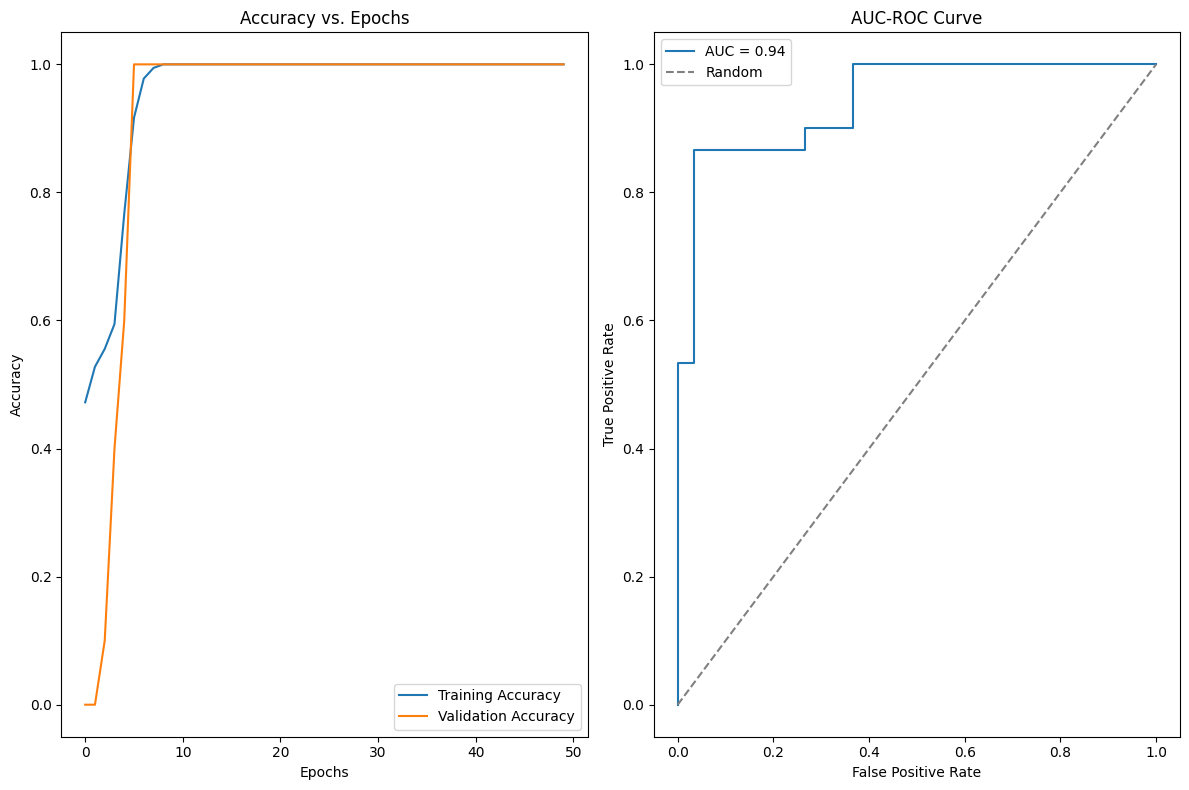

Test loss: 0.6126617193222046
Test accuracy: 0.9166666865348816
Sensitivity(recall): 0.8666666666666667
Specificity: 0.9666666666666667
Precision: 0.9629629629629629
F1 Score: 0.912280701754386
AUC-ROC Score: 0.9433333333333332
[[29  1]
 [ 4 26]]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              8392704   
     

In [ ]:
model4 = Sequential()
#model4.add(Dense(512, input_dim=(1024),  activation='relu'))
#model4.add(layers.Dropout(0.5))
model4.add(Dense(1024, input_dim=(1024), activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(Dense(2048,  activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(Dense(4096,  activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(Dense(8192,  activation='relu'))
model4.add(Dense(2,  activation='softmax'))
print(model4.summary())


#model4.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model = Model(inputs=base_model.input, outputs=predictions)
model4.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/Colab Notebooks/model4.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

# EarlyStopping
#early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

#ReduceLROnPlateau to stabilize the training process of the model
#rop_callback = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 10, verbose = 1, factor = 0.5, min_lr = 0.000001)



history =  model4.fit(
    x = merged_feature_train,
    y = to_categorical(y_train_ml_dl, num_classes=2),
    epochs=50,
    #batch_size = 50,
    #validation_data=(X_test, y_test),
    validation_split = 0.05,
    callbacks = [tl_checkpoint_1]#, early_stop, rop_callback]
)

#model4 = tensorflow.keras.models.load_model('/content/model4.h5')
model4.summary()

# Evaluate the model
scores = model4.evaluate(merged_feature_test, to_categorical(y_test_ml_dl, num_classes=2), verbose=1)
y_pred_dl = model4.predict(merged_feature_test)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(to_categorical(y_test_ml_dl, num_classes=2), axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

# Plot training history
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Corrected ylabel to 'Accuracy'
plt.title('Accuracy vs. Epochs')
plt.legend()

# Plot AUC-ROC
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_dl[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Sensitivity(recall):', recall)
print('Specificity:', specificity)
print('Precision:', precision_score(y_true_classes, y_pred_classes))
print('F1 Score:', f1_score(y_true_classes, y_pred_classes))
print('AUC-ROC Score:', roc_auc_score(y_true_classes, y_pred_dl[:, 1]))
print(conf_matrix)
model4.summary()


In [ ]:
def train_evaluate_rfe(classifier,  X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl,   y_test_ml_dl, plot_roc=False, plot_f1=False, plot_corr=False, plot_learning_curve = False):

      # Train the model using the selected features
      model = classifier
      model.fit(X_train_ml_dl, y_train_ml_dl)

      y_pred = model.predict(X_test_ml_dl)

      # Predict probabilities for each class on the test set
      y_prob = model.predict_proba(X_test_ml_dl)
       # Calculate AUC-ROC score for the positive class
      fpr, tpr, thresholds = roc_curve(y_test_ml_dl, y_prob[:, 1])
      auc_roc = auc(fpr, tpr)
      # Calculate AUC-ROC score for the positive class
      auc_roc_score = roc_auc_score(y_test_ml_dl, y_prob[:, 1])

      # Print metrics
      accuracy = accuracy_score(y_test_ml_dl, y_pred)
      print(y_test_ml_dl, y_pred)
      precision = precision_score(y_test_ml_dl, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test_ml_dl, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test_ml_dl, y_pred)
      # specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

      # Handle the case when there are no true negatives
      if conf_matrix[0, 0] + conf_matrix[0, 1] != 0:
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
      else:
        specificity = 0.0
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

      print(f"\nMetrics for {type(classifier).__name__}:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc_score:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

      if plot_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_roc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

      # Plot F1 score over different thresholds
      if plot_f1:
        plt.figure(figsize=(8, 6))
        f1_scores = [f1_score(y_test_ml_dl, y_prob[:, 1] > threshold) for threshold in thresholds]
        plt.plot(thresholds, f1_scores, label='F1 Score')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score over Different Thresholds')
        plt.legend()
        plt.show()

      # Print correlation matrix
      if plot_corr:
        corr_matrix = X_train_ml_dl.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Selected Features')
        plt.show()

      if plot_learning_curve:
        train_sizes, train_scores, validation_scores = learning_curve(classifier, X_train_ml_dl, y_train_ml_dl, cv=80, scoring='accuracy', train_sizes=np.linspace(0.1, 0.8, 10))
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training Score")
        plt.plot(train_sizes, np.mean(validation_scores, axis=1), 'o-', color="g", label="Validation Score")

        plt.xlabel("Training examples")
        plt.ylabel("Accuracy Score")
        plt.title("Learning Curve")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()


# Extra Trees Classifier
classifier = ExtraTreesClassifier(n_estimators=100, random_state=20)
train_evaluate_rfe(classifier, X_train_ml_dl, y_train_ml_dl, X_test_ml_dl, y_test_ml_dl,  plot_learning_curve=False)

#Logistic Regression
classifier = LogisticRegression(max_iter=100,penalty='l1', solver='liblinear')
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl, plot_learning_curve=False)

# Decision Tree
classifier = DecisionTreeClassifier(random_state=104)
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl)

# Define an SVM classifier
from sklearn.svm import SVC
classifier = SVC(kernel= 'linear', C= 0.1, gamma= 0.1, degree= 2, probability=True, random_state=42) #87
#classifier = SVC(kernel= 'rbf', C= 0.1, gamma= 'auto', degree= 2, probability=True, random_state=42) 89
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl,plot_roc=False, plot_f1=False, plot_corr=False, plot_learning_curve=False)

# HistGradientBoosting Classifier
hist_classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
train_evaluate_rfe(hist_classifier , X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl, plot_roc=False, plot_f1=False, plot_corr=False, plot_learning_curve=False)

# Random Forest
classifier = RandomForestClassifier(n_estimators=100, random_state=29)
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl,plot_learning_curve=False)

# AdaBoost Classifier
classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl, plot_learning_curve=False)

# XGBoost Classifier
classifier = XGBClassifier(n_estimators=100, random_state=42)
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl, plot_learning_curve=False)

# Gradient Boosted Trees
classifier = GradientBoostingClassifier(n_estimators=100, random_state=59)
train_evaluate_rfe(classifier, X_train_ml_dl,  y_train_ml_dl, X_test_ml_dl, y_test_ml_dl, plot_learning_curve=False)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1]

Metrics for ExtraTreesClassifier:
Accuracy: 0.92
Precision: 0.92
Sensitivity (Recall): 0.93
Specificity: 0.90
F1 Score: 0.92
AUC-ROC Score: 0.98
Confusion matrix:
 [[27  3]
 [ 2 28]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1]

Metrics for LogisticRegression:
Accuracy: 0.83
Precision: 0.83
Sensitivity (Recall): 0.83
Specificity: 0.83
F1 Score: 0.83
AUC-ROC Score: 0.95
Confusion matrix:
 [[25  5]
 [ 5 25]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 1 0 0 0 1 0 

In [3]:
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
testing_path = '/content/gdrive/MyDrive/Colab Notebooks/dataset_val/dataset_val/test/healthy/NM2087.png'
X_testing = []
image = load_img(testing_path, target_size=(224, 224))
image = img_to_array(image)
X_testing.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
#X_testing.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
y_test = [1]
y_test = np.array(y_test)
X_testing = np.array(X_testing)

X_testing_dl = []
image_dl = load_img(testing_path, target_size=(224, 224,3))
image_dl = img_to_array(image_dl)
X_testing_dl.append(image_dl)
X_testing_dl = np.array(X_testing_dl)

In [4]:
from skimage.feature import graycomatrix, graycoprops
imgs = X_testing.astype(np.int32)
labels = y_test.astype(np.int32)
print(imgs)
#cv2_imshow(imgs[0])


# ----------------- calculate greycomatrix() & greycoprops() for angle 0°, 30°, 45°, 60°, 90°, 120°, 135°, 150°, 180°----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[50], agls=[0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi], lvl=512, sym=True, norm=True):
#[0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []

for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = [0, np.pi/6 , np.pi/4,  np.pi/3, np.pi/2, 2*np.pi/3 , 3*np.pi/4, 5*np.pi/6, np.pi]
for name in properties :
    for ang in angles:
        columns.append(name + "_" + str(ang))

columns.append("label")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)
glcm_df.shape


from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])

hog_df['label'] = labels
hog_df.shape

from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=200):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']), glcm_df], axis=1)
#combined_df = glcm_df
#combined_df = lbp_df
#combined_df = hog_df
print(combined_df)
# Assuming 'label' is the target variable

X_test_df = combined_df.drop(columns=['label'])
y_test_df = combined_df['label']

#X = combined_df.drop(combined_df.index[-1])
#y = combined_df.iloc[-1]

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled_test = scaler_combined.fit_transform(X_test_df.values)

[[[ 9  9  8 ...  6  6 10]
  [ 4  4  6 ...  8  8  7]
  [ 6  6  6 ...  7  7  6]
  ...
  [ 6  6  7 ...  8  9 11]
  [10 10  5 ...  5  5 11]
  [ 9  9  5 ...  7  7 11]]]
      hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0  0.220533  0.123673  0.110094  0.122824  0.220533  0.121295  0.133647   

      hog_7     hog_8     hog_9  ...  energy_0  energy_0.5235987755982988  \
0  0.158687  0.220533  0.145844  ...  0.013133                    0.01191   

   energy_0.7853981633974483  energy_1.0471975511965976  \
0                   0.012145                   0.012358   

   energy_1.5707963267948966  energy_2.0943951023931953  \
0                   0.014972                   0.012502   

   energy_2.356194490192345  energy_2.6179938779914944  \
0                  0.012218                   0.011997   

   energy_3.141592653589793  label  
0                  0.013133      1  

[1 rows x 5665 columns]


In [5]:
best_columns = np.genfromtxt('/content/gdrive/My Drive/Colab Notebooks/best_columns.csv', delimiter=',', skip_header = 1)
best_columns = [int(i) for i in best_columns]
print(best_columns)
X_scaled_test = X_scaled_test[:, best_columns]

[16, 44, 52, 56, 73, 75, 99, 112, 148, 152, 246, 262, 298, 301, 302, 322, 326, 333, 348, 364, 381, 386, 405, 428, 463, 477, 484, 487, 514, 522, 559, 576, 583, 601, 607, 624, 625, 626, 631, 632, 633, 638, 646, 657, 662, 671, 676, 684, 685, 732, 772, 805, 812, 830, 877, 893, 937, 952, 954, 955, 976, 1007, 1016, 1025, 1031, 1033, 1036, 1040, 1047, 1060, 1066, 1115, 1117, 1141, 1156, 1233, 1276, 1293, 1300, 1322, 1325, 1345, 1349, 1352, 1354, 1355, 1361, 1365, 1368, 1369, 1373, 1376, 1378, 1379, 1393, 1397, 1398, 1404, 1416, 1419, 1432, 1437, 1450, 1461, 1465, 1470, 1474, 1489, 1491, 1494, 1522, 1539, 1541, 1555, 1557, 1559, 1561, 1585, 1609, 1631, 1633, 1654, 1655, 1676, 1683, 1700, 1726, 1737, 1741, 1742, 1750, 1752, 1753, 1754, 1761, 1769, 1774, 1776, 1777, 1778, 1784, 1793, 1798, 1832, 1837, 1840, 1856, 1857, 1870, 1889, 1894, 1903, 1920, 1934, 1949, 1957, 1958, 1959, 1961, 1973, 1985, 2040, 2064, 2083, 2089, 2098, 2099, 2113, 2126, 2138, 2141, 2150, 2152, 2153, 2154, 2158, 2175, 2176,

In [6]:

#X_scaled_test = X_scaled_test.reshape(X_scaled_test.shape[0], -1)
print(X_scaled_test.shape)


(1, 512)


In [9]:
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
"""
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/My Drive/Colab Notebooks/vgg19_best_model.tflite")
interpreter.allocate_tensors()

# Convert TensorFlow Lite model to Keras model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/gdrive/My Drive/Colab Notebooks/vgg19_best_model.tflite")
keras_model = converter.convert()

# Load the Keras model
model = tf.keras.models.load_model(keras_model)
#model5 = tensorflow.keras.models.load_model(best_weights_path)

import tensorflow as tf
#!pip install onnx
import onnx
#!pip install onnx_tf
from onnx_tf.backend import prepare

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/My Drive/Copy of vgg19_best_model.tflite")
interpreter.allocate_tensors()

# Convert TensorFlow Lite model to TensorFlow model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/gdrive/My Drive/Copy of vgg19_best_model.tflite")
tf_model = converter.convert()

# Convert TensorFlow model to ONNX model
onnx_model = onnx.load_model(tf_model)

# Load ONNX model using ONNX runtime
sess = onnxruntime.InferenceSession(onnx_model.SerializeToString())

# Now you can use the loaded model for inference

"""
from keras.models import load_model

# Load the model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/vgg19_best_weights.tf')
print(model.predict(X_testing_dl))
#print(model.layers[-7].output)
extract = Model(model.inputs, model.layers[-7].output) #top_model = Dropout(0.6)(top_model)
features_test = extract.predict(X_testing_dl)
features_test = features_test.reshape(features_test.shape[0], -1)

# Flatten the features
print(features_test.shape)


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [ ]:
X_scaled_test_ml_dl = np.concatenate((X_scaled_test, features_test),axis=1)

In [ ]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
#joblib.dump(hist_classifier, 'classifier.pkl')

# Load the model from the file
hist_from_joblib = joblib.load('/content/gdrive/My Drive/Colab Notebooks/classifier.pkl')
# Use the loaded pickled model to make predictions
print(hist_from_joblib.predict(X_scaled_test_ml_dl.reshape(1,-1)))


[0]
